# Exam Project for NI-SCR

This repository contains the exam project for the "NI-SCR" course of Statistical\
 analysis of time series at FIT CTU in Prague for the academic year 22/23.\
  The goal of the project is to analyze a given time series dataset using\
   statistical methods and techniques. The project should include an exploration\
    of the data, identifying patterns and trends, and making predictions.

## Imports

In [2]:
from itertools import product
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pmd
from pmdarima.arima import ARIMA
from pmdarima.metrics import smape
from sklearn.model_selection import ParameterGrid
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

## Data

The data from Eurostat's databrowser covers various indicators of energy\
 consumption, production and trade for the period from 2008 to 2022 specifically\
  for the Czech Republic. The table provided below contains codes and descriptions\
   for several indicators related to natural gas, electricity and oil.

- The `IS-CNG-TJ` code represents the total consumption of natural gas in\
TeraJoules (TJ) and can be used to analyze the overall consumption of natural\
gas in Czech Republic.
- The `IS-ING-TJ` code represents the imports of natural gas in TeraJoules (TJ)\
 and can be used to understand the dependency on natural gas imports\
  in Czech Republic.
- The `IS-PEL-GWH` code represents the production of electricity in GigaWatt\
hours (GWh) and can be used to analyze the domestic production of electricity\
 in Czech Republic.
- The `IS-CEL-GWH` code represents the consumption of electricity in GigaWatt\
 hours (GWh) and can be used to analyze the overall consumption of electricity\
  in Czech Republic.
- The `IS-IEL-GWH` code represents the imports of electricity in GigaWatt hours\
 (GWh) and can be used to understand the dependency on electricity imports\
  in Czech Republic.
- The `IS-ICO-T` code represents the imports of crude oil in 1000 metric tons\
 and can be used to analyze the dependency on crude oil imports in Czech Republic.

By using these codes you can access the data.

Data source: https://ec.europa.eu/eurostat/databrowser/view/EI_ISEN_M__custom_4569965/default/line?lang=en

| Code      | Description                        |
|:----------|-----------------------------------:|
| IS-CNG-TJ |Total consumption of natural gas, TJ|
| IS-ING-TJ |Imports of natural gas, TJ          |
| IS-PEL-GWH| Production of electricity - GWh    |
| IS-CEL-GWH| Consumption of electricity - GWh   |
| IS-IEL-GWH| Imports of electricity - GWh       |
| IS-ICO-T  |Imports of crude oil - 1000t        |


In [3]:
# Load data
FILE_PATH = './data/ei_isen_m__custom_4580131_linear.csv'

df = pd.read_csv(FILE_PATH)
df.head()

,DATAFLOW,LAST UPDATE,freq,s_adj,indic,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:EI_ISEN_M(1.0),18/01/23 11:00:00,M,NSA,IS-CEL-GWH,CZ,2008-01,6352.0,NaN
1,ESTAT:EI_ISEN_M(1.0),18/01/23 11:00:00,M,NSA,IS-CEL-GWH,CZ,2008-02,5878.0,NaN
2,ESTAT:EI_ISEN_M(1.0),18/01/23 11:00:00,M,NSA,IS-CEL-GWH,CZ,2008-03,6019.0,NaN
3,ESTAT:EI_ISEN_M(1.0),18/01/23 11:00:00,M,NSA,IS-CEL-GWH,CZ,2008-04,5492.0,NaN
4,ESTAT:EI_ISEN_M(1.0),18/01/23 11:00:00,M,NSA,IS-CEL-GWH,CZ,2008-05,5111.0,NaN


Preprocess data


In [4]:
df_clean = (
    df[
        ['indic','TIME_PERIOD','OBS_VALUE']
    ]
    .rename(columns={
        'indic':'indicator',
        'TIME_PERIOD':'date',
        'OBS_VALUE':'value'
    })
    .assign(date = lambda df: pd.to_datetime(df['date']))
)
df_clean.head()

,indicator,date,value
0,IS-CEL-GWH,2008-01-01,6352.0
1,IS-CEL-GWH,2008-02-01,5878.0
2,IS-CEL-GWH,2008-03-01,6019.0
3,IS-CEL-GWH,2008-04-01,5492.0
4,IS-CEL-GWH,2008-05-01,5111.0


We are going to work only with gas consumption data


In [5]:
df_cng = (
    df_clean[
        df_clean['indicator'] == 'IS-CNG-TJ'
    ]
    .iloc[:,1:]
    .rename(columns={
        'value':'consumption'
    })
    .set_index('date')
)
df_cng.head()

,consumption
date,
2008-01-01,47394.0
2008-02-01,40149.0
2008-03-01,40354.0
2008-04-01,27020.0
2008-05-01,16660.0


## Utils

In [6]:
def walk_forward_validation(
    data: np.ndarray,
    window_size: int,
    target_size: int = 1,
    keep_history: bool = False,
    axis: int = 0,
):
    """
    Perform walk-forward validation
    Parameters
    ----------
    data : np.ndarray
        3D input array of shape (n_datasets, n_timepoints, n_features)
    window_size : int
        Number of timepoints used for training in each iteration.
    target_size : int, optional
        Number of timepoints used for testing in each iteration, by default 1.
    keep_history : bool, optional
        If True, the indices of the previously used training examples are also included in the training set, by default False.
    axis : int, optional
        Axis along which to perform the walk-forward validation, by default 1.
    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple of 2 1D arrays, where the first array contains the indices of the training examples and the second array contains the indices of the test examples.
    """
    n_timepoints = data.shape[axis]
    indices = np.arange(n_timepoints)
    test_starts = range(window_size, n_timepoints, target_size)
    for test_start in test_starts:
        train_end = test_start
        test_end = test_start + target_size
        train_start = train_end - window_size
        if keep_history:
            yield (indices[:train_end], indices[test_start:test_end])
        else:
            yield (
                indices[train_start:train_end],
                indices[test_start:test_end],
            )

def acf_pacf(y, lags):
    fig = plt.Figure(figsize=(14,6))
    ax1 = plt.subplot2grid((1,2), (0, 0))
    ax2 = plt.subplot2grid((1,2), (0, 1))
    plot_acf(y, lags=lags, ax=ax1)
    plot_pacf(y, lags=lags, ax=ax2, method='ywm')
    plt.show()

def adf(
    y,
    maxlag = None,
    regression="c",
    autolag="AIC",
    store=False,
    regresults=False
):
    res = adfuller(y, maxlag, regression, autolag, store, regresults)    
    print('ADF')
    print(f'Test statistic {res[0]}')
    print(f'P value {res[1]}')
    print(f'Used lag {res[2]}')
    print(f'Number of obs used {res[3]}')
    print(f'Critical values {res[4]}')
    print(f'Maximized information criterion {res[5]}')
    
def kp(
    y,
    regression = "c",
    nlags = "auto",
    store = False,
):
    res = kpss(y, regression, nlags, store)  
    print('KPSS')
    print(f'Test statistic {res[0]}')
    print(f'P value {res[1]}')
    print(f'Lags {res[2]}')
    print(f'Critical values {res[3]}')

## Analysis

What we can see from initial plotting of the data:

- Clear 12 month seasonality
- Trend seems nearly constant over the period

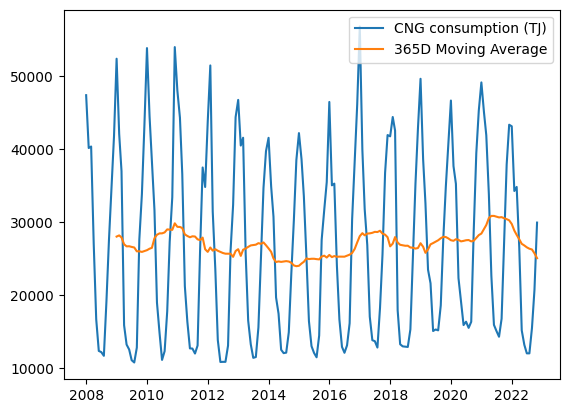

In [7]:
plt.plot(df_cng, label='CNG consumption (TJ)')
plt.plot(df_cng.rolling('365D').mean()[12:], label='365D Moving Average')
plt.legend()

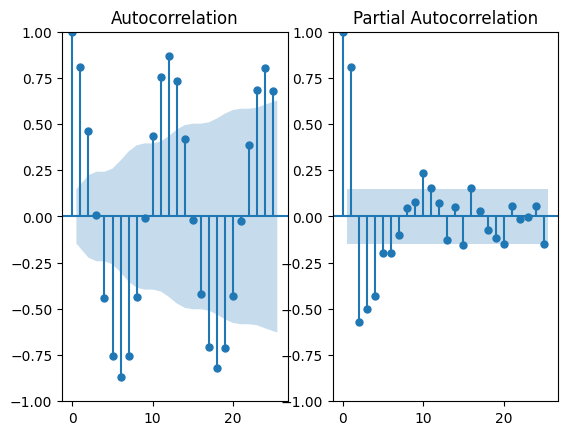

In [8]:
acf_pacf(df_cng, lags=25)

In [9]:
adf(df_cng, autolag='AIC', maxlag=25)
print('-------------------------------------------')
kp(df_cng, regression='ct', nlags="auto")

ADF
Test statistic -1.6261779005238544
P value 0.4694919780202747
Used lag 23
Number of obs used 155
Critical values {'1%': -3.4732590518613002, '5%': -2.880374082105334, '10%': -2.5768120811654525}
Maximized information criterion 2949.756679550577
-------------------------------------------
KPSS
Test statistic 0.02230252724993121
P value 0.1
Lags 6
Critical values {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


/root/.cache/pypoetry/virtualenvs/scr-n7un528A-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


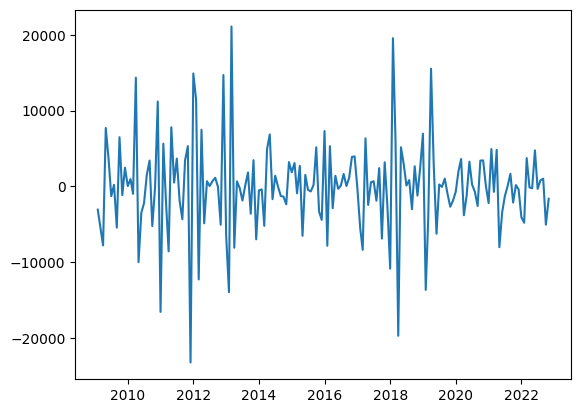

In [10]:
df_diffed = df_cng.diff().diff(12).dropna()
plt.plot(df_diffed)

In [11]:
adf(df_diffed, autolag='AIC', maxlag=25)
print('-------------------------------------------')
kp(df_diffed, regression='ct', nlags="auto")

ADF
Test statistic -3.5425670561860856
P value 0.006958859692489593
Used lag 24
Number of obs used 141
Critical values {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
Maximized information criterion 2716.701670556451
-------------------------------------------
KPSS
Test statistic 0.019361136396175087
P value 0.1
Lags 3
Critical values {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


/root/.cache/pypoetry/virtualenvs/scr-n7un528A-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


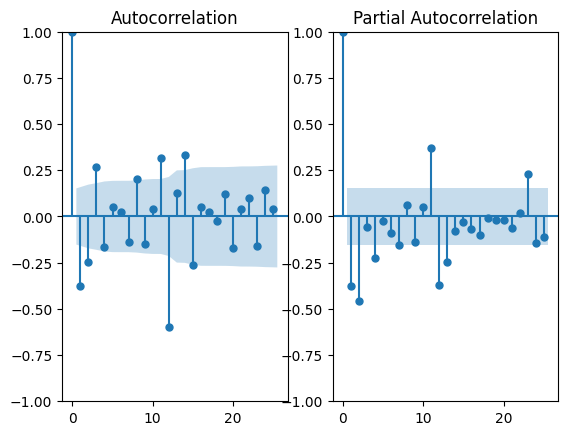

In [12]:
acf_pacf(df_diffed, lags=25)

## Modelling

We are going to use last 6 months to compare the models


In [13]:
train = df_cng.iloc[:-6]
test = df_cng.iloc[-6:]

First we are going to train the model on all training data.

In [14]:
res = pmd.auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=3, max_q=3, m=12, d=1, D=1,
    start_P=0, max_P=2, start_Q=0, max_Q=2,
    information_criterion='aic', trace=False,
    seasonal=True, n_jobs=32, stepwise=False
)

In [15]:
print('Best model found')
print(res.get_params()['order'])
print(res.get_params()['seasonal_order'])
print(f'SMAPE score {smape(test, res.predict(6))}')


Best model found
(0, 1, 2)
(0, 1, 1, 12)
SMAPE score 9.630361354447873


In [40]:
from numpy.linalg import LinAlgError

def arima_fit_score(train, ps):
    score = []
    aic = []
    for (train_idx, test_idx) in walk_forward_validation(train, 60, 6, True, axis=0):
        train_ = train.iloc[train_idx]
        test_ = train.iloc[test_idx]
        model = ARIMA(
            ps['order'], 
            ps['seasonal_order'] + ps['seasonal'],
            with_intercept=ps['intercept'],
            suppress_warnings=True,
            max_iter=35
        )
        try:
            res_= model.fit(train_)
        except LinAlgError:
            return float('inf'), ps
            
        # https://github.com/alkaline-ml/pmdarima/issues/404
        try:
            y_pred = res_.predict(len(test_))
        except ValueError:
            y_pred = [np.nan] * len(test_) 
        score.append(smape(test_, y_pred))
        aic.append(model.aic())
    return np.median(aic), ps, np.mean(score)

In [41]:
from joblib import Parallel, delayed

param_grid = {
    'order': list(product(range(3),repeat=3)),
    'seasonal_order': list(product(range(2),repeat=3)),
    'seasonal' : [(12,)],
    'intercept' : [True, False]
}

results = Parallel(n_jobs=40)(delayed(arima_fit_score)(train, ps) for ps in ParameterGrid(param_grid))

In [43]:
best_res = min(results, key = lambda t:t[0])

In [44]:
best_res

(1996.3786861579122,
 {'intercept': False,
  'order': (0, 2, 2),
  'seasonal': (12,),
  'seasonal_order': (1, 1, 1)},
 14.457140170239716)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  173
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1571.362
Date:                              Fri, 20 Jan 2023   AIC                           3150.725
Time:                                      11:02:13   BIC                           3163.025
Sample:                                  01-01-2008   HQIC                          3155.720
                                       - 05-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3238      0.050     -6.527      0.000      -0.421      -0.227
ma.L2         -0.12

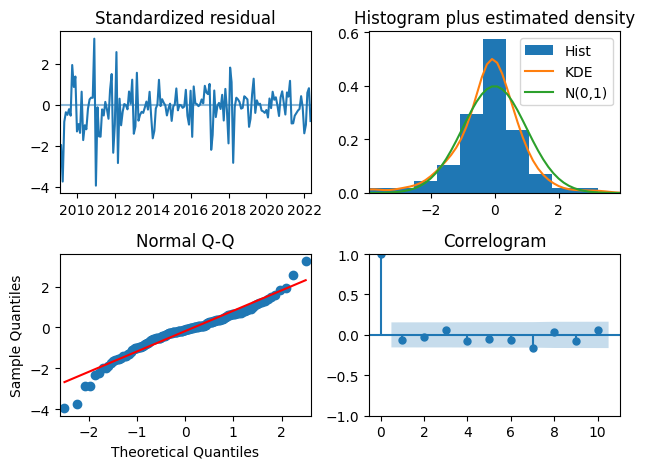

In [45]:
print(res.summary())
res.plot_diagnostics().tight_layout()

/root/.cache/pypoetry/virtualenvs/scr-n7un528A-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/.cache/pypoetry/virtualenvs/scr-n7un528A-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


12.507820202805114
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  173
Model:             SARIMAX(0, 2, 2)x(1, 1, [1], 12)   Log Likelihood               -1561.146
Date:                              Fri, 20 Jan 2023   AIC                           3132.292
Time:                                      11:02:16   BIC                           3147.637
Sample:                                  01-01-2008   HQIC                          3138.523
                                       - 05-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4688      0.118    -12.467      0.000      -1.700      -1.238


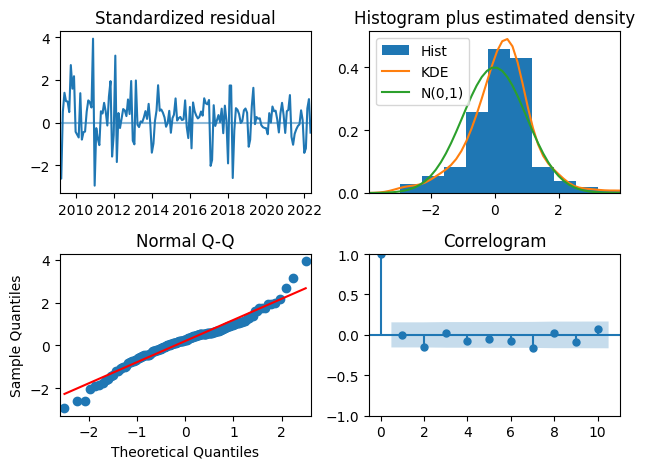

In [46]:
m_mfv = ARIMA(best_res[1]['order'], best_res[1]['seasonal_order'] + best_res[1]['seasonal'], with_intercept=best_res[1]['intercept'])
r_mfv = m_mfv.fit(train)
print(smape(test, r_mfv.predict(len(test))))
print(r_mfv.summary())
r_mfv.plot_diagnostics().tight_layout()

(0.0, 60000.0)

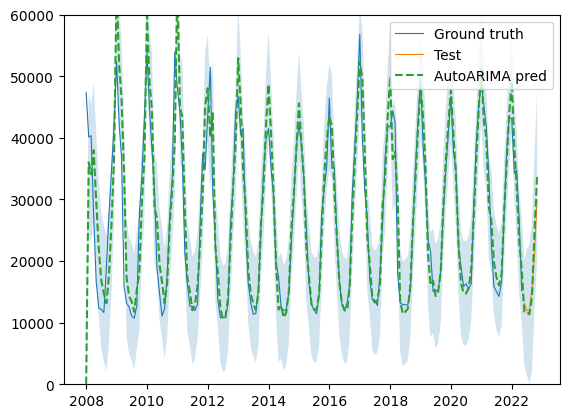

In [47]:
plt.plot(train, lw=0.8, label='Ground truth')
plt.plot(test, lw=0.8, label='Test')
pred, ci = res.predict_in_sample(end=178, return_conf_int=True)
plt.plot(pred, '--', label='AutoARIMA pred',)
plt.fill_between(pred.index, ci[:,0], ci[:,1], alpha=0.2)
plt.legend()
plt.ylim(0,60000)

(0.0, 60000.0)

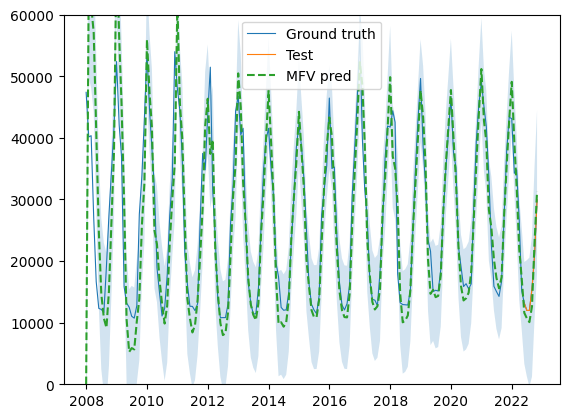

In [48]:
plt.plot(df_cng, lw=0.8, label='Ground truth')
plt.plot(test, lw=0.8, label='Test')
pred, ci = r_mfv.predict_in_sample(end=178, return_conf_int=True)
plt.plot(pred,'--', label='MFV pred')
plt.fill_between(pred.index, ci[:,0], ci[:,1], alpha=0.2)
plt.legend()
plt.ylim(0,60000)